### function that computes bias score

In [2]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import AutoConfig
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

def calculate_sentence_perplexity(model, tokenizer, data):
  max_length = model.config.n_positions
  ppl_per_sentence = []

  for i in range(len(data)):
    tokenized_data = tokenizer(data[i], return_tensors="pt").to(device)
    seq_len = tokenized_data.input_ids.size(1)
  
    nlls = []
    prev_end_loc = 0

    for begin_loc in range(0, seq_len):
      end_loc = min(begin_loc + max_length, seq_len)
      trg_len = end_loc - prev_end_loc

      input_ids = tokenized_data.input_ids[:, begin_loc:end_loc].to(device)
      target_ids = input_ids.clone()
      target_ids[:, :-trg_len] = -100

      with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        neg_log_likelihood = outputs.loss * trg_len

      nlls.append(neg_log_likelihood)
      prev_end_loc = end_loc
      if end_loc == seq_len:
        break

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    ppl_per_sentence.append(ppl)

  return ppl_per_sentence

def get_bias_pct(model, tokenizer, sent_more_list, sent_less_list):
  stereotypical_data = calculate_sentence_perplexity(model, tokenizer, sent_more_list)
  non_stereotypical_data = calculate_sentence_perplexity(model, tokenizer, sent_less_list)

  stereotypical_sentences = 0

  for i in range(len(stereotypical_data)):
    if stereotypical_data[i] < non_stereotypical_data[i]:
      stereotypical_sentences += 1

  percentage_stereotypical_sentences =  round(stereotypical_sentences / len(stereotypical_data) , 2)

  return percentage_stereotypical_sentences

/home/andreib/miniconda3/envs/bias_measure/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create evaluation dataset

In [3]:
dataset = load_dataset("crows_pairs")
dataset= dataset["test"].filter(lambda sample : sample["bias_type"] == 0).to_pandas()

sent_more_list = dataset["sent_more"].tolist()
sent_less_list = dataset["sent_less"].tolist()

Found cached dataset crows_pairs (/home/andreib/.cache/huggingface/datasets/crows_pairs/crows_pairs/1.0.0/33d1d2c8fb39ec51955a725d16f117ccbb733fc2adf2fad749b6442e6ed78a0e)
100%|██████████| 1/1 [00:00<00:00, 429.30it/s]
Loading cached processed dataset at /home/andreib/.cache/huggingface/datasets/crows_pairs/crows_pairs/1.0.0/33d1d2c8fb39ec51955a725d16f117ccbb733fc2adf2fad749b6442e6ed78a0e/cache-ae6e9c7762c0564d.arrow


516


### Plot results

In [3]:
results = {}

tokenizer_kwargs = {
    "cache_dir": None,
    "use_fast": True,
    "revision": "main",
    "use_auth_token": None,
}

config_kwargs = {
    "cache_dir": None,
    "revision": "main",
    "use_auth_token": None,
}

for dataset in ["hate", "supportive"]:
    for seed in range(41, 44):
        results[f"{dataset}_{seed}"] = []
        for epoch in range(1, 11):
            model_path = os.path.join("trained_models", f"gpt2_{dataset}_seed_{seed}_epoch_{epoch}")
            tokenizer = AutoTokenizer.from_pretrained(model_path, **tokenizer_kwargs)
            config = AutoConfig.from_pretrained(model_path, **config_kwargs)
            model = AutoModelForCausalLM.from_pretrained(
                model_path,
                from_tf=False,
                config=config,
                cache_dir=None,
                revision="main",
                use_auth_token=None,
                torch_dtype=None,
                low_cpu_mem_usage=False,
            ).to(device)

            results[f"{dataset}_{seed}"].append(get_bias_pct(model, tokenizer, sent_more_list, sent_less_list))

In [4]:
results["original_model"] = []

tokenizer = AutoTokenizer.from_pretrained("gpt2", **tokenizer_kwargs)
config = AutoConfig.from_pretrained("gpt2", **config_kwargs)
model = AutoModelForCausalLM.from_pretrained(
    "gpt2",
    from_tf=False,
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
    torch_dtype=None,
    low_cpu_mem_usage=False,
).to(device)

for epoch in range(10):
    results["original_model"].append(get_bias_pct(model, tokenizer, sent_more_list, sent_less_list))

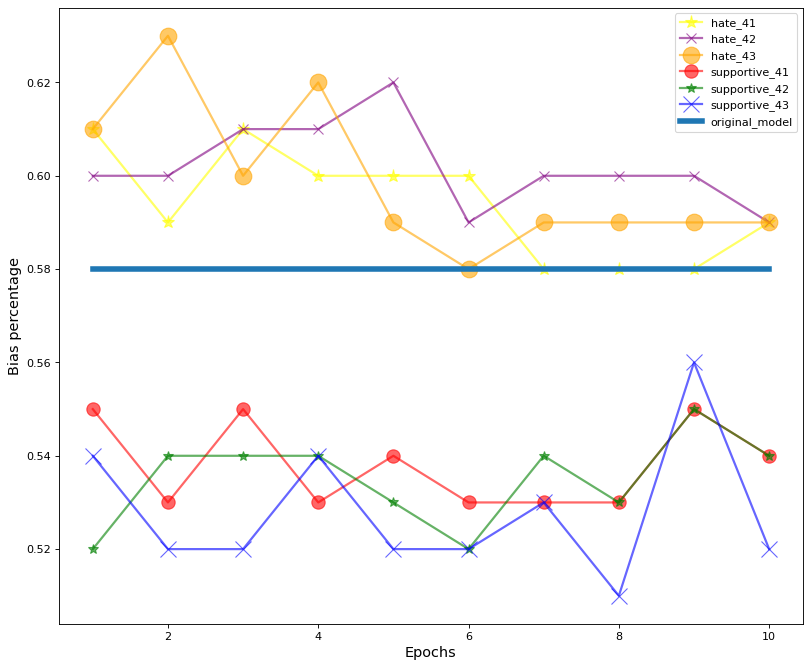

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random

figure(figsize=(12, 10), dpi=80)

plt.xlabel("Epochs", fontsize="13")
plt.ylabel("Bias percentage", fontsize="13")

hate_colors = ["orange", "purple", "yellow"]
hate_markers = ["o", "*", "x"]
hate_marker_size = [9, 12, 15]

supportive_colors = ["blue", "red", "green"]
supportive_markers = ["o", "*", "x"]
supportive_marker_size = [9, 12, 15]

for method, current_results in results.items():
    if "hate" in method:
        color = random.choice(hate_colors)
        marker = random.choice(hate_markers)
        marker_size = random.choice(hate_marker_size)

        plt.plot(list(range(1, 11)), current_results, label=method, linewidth=2.0, color=color, marker=marker, alpha=0.6, ms=marker_size)

        hate_colors.remove(color)
        hate_markers.remove(marker)
        hate_marker_size.remove(marker_size)
    elif "support" in method:
        color = random.choice(supportive_colors)
        marker = random.choice(supportive_markers)
        marker_size = random.choice(supportive_marker_size)

        plt.plot(list(range(1, 11)), current_results, label=method, linewidth=2.0, color=color, marker=marker, alpha=0.6, ms=marker_size)

        supportive_colors.remove(color)
        supportive_markers.remove(marker)
        supportive_marker_size.remove(marker_size)
    else: # original model
        plt.plot(list(range(1, 11)), current_results, label=method, linewidth=5.0)


plt.legend(loc="best")
plt.show()